# 👾 PixelCNN using Tensorflow distributions

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset using Tensorflow distributions

In [10]:
%load_ext autoreload
%autoreload 2
import time
startTime=time.time()
import os
import math
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

import numpy as np

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models, optimizers, callbacks
import tensorflow_probability as tfp 

from notebooks.utils import display, sample_batch #书作者自编模块

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [11]:
#可调参数
BATCH_SIZE = 16 #查看显存占用比例“nvidia-smi”，一般小于98~99%较好，显示100%容易出错。书作者128。一张图片实际上48*192=9216个样本
num_resnet=3 #残差网络数目，书作者、官网MNIST实例取1，tf默认5
num_hierarchies=1 #书作者、官网MNIST实例取2，tf默认3
num_filters=32 #神经元数目，取32生成图片效果不好、loss很难降低。128模型参数量10百万、64模型参数量2.5百万、32模型参数量0.6百万（参数量例子vae1.3百万、gan2.3百万，而且图像尺寸128*512），书作者、官网MNIST实例取32，tf默认160。
num_logistic_mix=1 #几个logistic分布组成的混合分布，书作者、官网MNIST实例取5，tf默认10。灰度图像取1即可，可以加快损失下降
receptive_field_dims=(5,7) #tf默认(3,3)。查看源代码“tensorflow_probability\python\distributions\pixel_cnn.py”：rows, cols = self._receptive_field_dims； Conv2D( kernel_size=(2 * rows - 1, cols),...），可见第一个值是可见像素的最大行数、第二个值卷积核列数。

#固定参数
EPOCHS = 60 #书作者10
learning_rate=0.001 #书作者0.001
num_img=20 #num_img=20时显存占用96%
#temperature=1 #tfp.distributions.PixelCNN模型中没有这个参数
IMAGE_SIZE =  (48, 192) #再小清晰度就不满足了
train_dir=".\\png 192x48_GRAY\\" #文件名字符数目不能过多，否则出错，故在旋转、缩放、平移变换时减少文件名字符。
steps_per_epoch=math.ceil(9600/BATCH_SIZE)  #2023.12.22。文件总数9600。math.ceil() 对浮点数向上取整。

## 1. Prepare the data <a name="prepare"></a>

In [12]:
# Load the data
train_data = utils.image_dataset_from_directory(
    train_dir, 
    labels=None,
    color_mode="grayscale", 
    image_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear", #双线性插值
)

Found 9600 files belonging to 1 classes.


(16, 48, 192, 1)


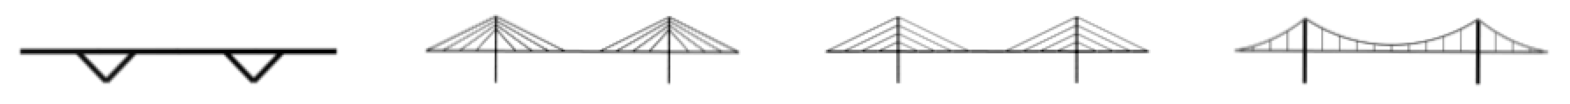

In [13]:
train_sample = sample_batch(train_data)
print(train_sample.shape) 
np.savetxt('train_sample[0]-1.txt', train_sample[0][:,:,0])  #像素值0~255
display(train_sample, n=4)

In [14]:
input_data =train_data

## 2. Build the PixelCNN <a name="build"></a>

In [15]:
# Define a Pixel CNN network
dist = tfp.distributions.PixelCNN( 
    image_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1),
    num_resnet=num_resnet, #残差网络数目，书作者、官网MNIST实例取1，tf默认5
    num_hierarchies=num_hierarchies, #层数，书作者、官网MNIST实例取2，tf默认3
    num_filters=num_filters, #神经元数目，书作者、官网MNIST实例取32，tf默认160
    num_logistic_mix=num_logistic_mix, #几个logistic分布组成的混合分布，书作者、官网MNIST实例取5，tf默认10
    receptive_field_dims=receptive_field_dims, #tf默认(3,3)
    dropout_p=0.3, #书作者、官网MNIST实例取0.3，tf默认0.5
) #其它参数默认即可。见官网https://tensorflow.google.cn/probability/api_docs/python/tfp/distributions/PixelCNN

# Define the model input
image_input = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

# Define the log likelihood for the loss fn
log_prob = dist.log_prob(image_input)

# Define the model
pixelcnn = models.Model(inputs=image_input, outputs=log_prob)
pixelcnn.add_loss(-tf.reduce_mean(log_prob))
pixelcnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 192, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.reshape_5 (TFOpLambda)      (None, 48, 192, 1)   0           ['input_4[0][0]']                
                                                                                                  
 tf.convert_to_tensor_11 (TFOpL  (None, 48, 192, 1)  0           ['tf.reshape_5[0][0]']           
 ambda)                                                                                           
                                                                                            

## 3. Train the PixelCNN <a name="train"></a>

In [16]:
# Compile and train the model
pixelcnn.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
)

In [17]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def generate(self):
        return dist.sample(self.num_img).numpy()

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate()
        display(
            generated_images,
            n=self.num_img,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=1)

In [18]:
history=pixelcnn.fit(
    input_data,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    verbose=True,
    #callbacks=[tensorboard_callback, img_generator_callback],
)

Epoch 1/60
600/600 [==============================] - 201s 318ms/step - loss: 8593.8320
Epoch 2/60
600/600 [==============================] - 191s 318ms/step - loss: 6072.8735
Epoch 3/60
600/600 [==============================] - 191s 318ms/step - loss: 5458.1567
Epoch 4/60
600/600 [==============================] - 191s 318ms/step - loss: 5048.0747
Epoch 5/60
600/600 [==============================] - 191s 318ms/step - loss: 4784.4272
Epoch 6/60
600/600 [==============================] - 191s 318ms/step - loss: 4553.9258
Epoch 7/60
600/600 [==============================] - 191s 318ms/step - loss: 4408.4141
Epoch 8/60
600/600 [==============================] - 191s 318ms/step - loss: 4238.3101
Epoch 9/60
600/600 [==============================] - 191s 318ms/step - loss: 4148.1270
Epoch 10/60
600/600 [==============================] - 191s 318ms/step - loss: 4025.2900
Epoch 11/60
600/600 [==============================] - 191s 318ms/step - loss: 3954.5342
Epoch 12/60
600/600 [=========

## 4. Generate images <a name="generate"></a>

In [19]:
#自加代码
pixelcnn.save_weights(os.path.join("./models/", 'pixelcnn.h5')) 
endTime=time.time()
print('How many minutes:',(endTime-startTime)/60)  #40轮113m/神经元数量64/BATCH_SIZE =48【40轮52m/神经元数量32/BATCH_SIZE =64】。GPU训练速度正常，但是生成图像速度奇慢。CPU速度更慢（训练、推理）。

How many minutes: 192.0433916091919


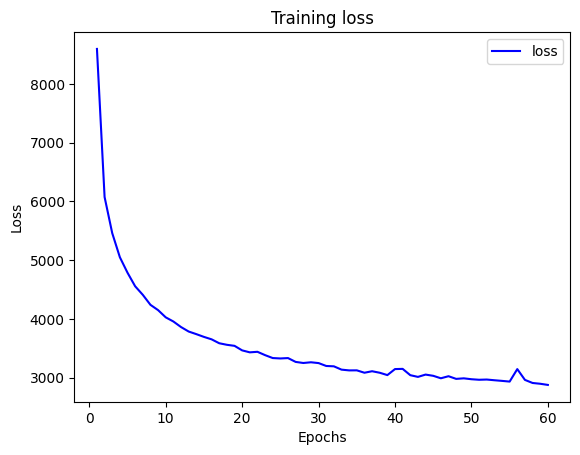

In [20]:
with open('history.history.txt', 'w') as file_object:
    file_object.write(str(history.history)+'\n')  #损失写入文件

history_dict = history.history
loss = history_dict['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


Saved to ./output/generated_img_a.png


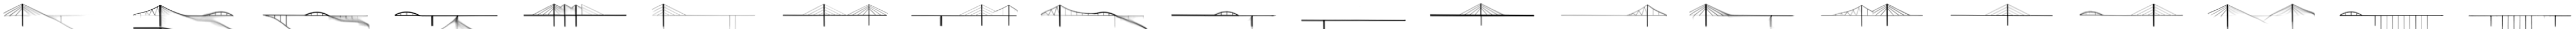

How many minutes: 25.285778152942658
(20, 48, 192, 1)


In [21]:
startTime=time.time()
generated_images = dist.sample(num_img).numpy() #查了官网、源代码，无温度参数，此时相当于temperature=1
display(generated_images, n=num_img,size=(160, 2),save_to="./output/generated_img_a.png") #之前gan模型经验size=(160, 2)这种比例清晰度高
endTime=time.time()
print('How many minutes:',(endTime-startTime)/60) #生成1、2、4张图片分别是15、15、18分钟，可见生成图片耗时与图片数量、模型容量关联不大.CPU速度更慢（训练、推理）。
#np.savetxt(os.path.join("./output/", 'generated_images[0].txt'), generated_images[0][:,:,0],fmt='%.3f')  #像素值0~255

for i in range(num_img):
    img = image.array_to_img(abs(generated_images[i]-255), scale=False) #scale设置为false，否则灰度可能会发生变化。
    img.save(os.path.join("./output/generated_images", 'generated_images_a%d.png'%i)) #要保持值不变，请以png格式。jpg文件值不同（压缩了图像）
print(generated_images.shape)

In [22]:
#论文中截屏使用
'''
dist = tfp.distributions.PixelCNN( 
    image_shape=(48, 192, 1),
    num_resnet=3, #最高级别块中残差层数目，官网MNIST实例取1，tfp默认5
    num_hierarchies=2, #最高级别块的数目(arXiv:1701.05517v1图2)，官网MNIST实例取2，tfp默认3
#查看源码"pixel_cnn.py"："for i in range(self._num_hierarchies)".每个“i”迭代构建一个最高级别的块
#（在arXiv:1701.05517v1的图2中被标识为“6层序列”，由“num_resnet=5”阶-1层和一个收缩高度/宽度维度的阶-2层组成）
    num_filters=32, #神经元数目，官网MNIST实例取32，tfp默认160
    num_logistic_mix=1, #几个logistic分布组成的混合分布，官网MNIST实例取5，tfp默认10。灰度图像取1可加快损失下降
    receptive_field_dims=(5,7), #tfp默认(3,3)。查看源码"pixel_cnn.py"：rows, cols = receptive_field_dims； 
#Conv2D( kernel_size=(2 * rows - 1, cols),...），可见第一个值是可见像素的最大行数、第二个值卷积核窗口列数。
    dropout_p=0.3, #官网MNIST实例取0.3，tfp默认0.5
) #其它参数默认。https://tensorflow.google.cn/probability/api_docs/python/tfp/distributions/PixelCNN

dist = tfp.distributions.PixelCNN( 
    image_shape=(48, 192, 1),
    num_resnet=3, #the number of ResNet layers within each highest-level block
    num_hierarchies=2, #the number of hightest-level blocks (in Figure 2 of arXiv:1701.05517v1)
#View Source "pixel_cnn.py"："for i in range(self._num_hierarchies)". Each `i` iteration builds one of the 
#highest-level blocks (identified as 'Sequence of 6 layers' in the figure 2 of arXiv:1701.05517v1, consisting 
#of `num_resnet=5` stride-1 layers, and one stride-2 layer that contracts the height/width dimensions).
    num_filters=32, #the number of convolutional filters
    num_logistic_mix=1, #number of components in the logistic mixture distribution.
#Taking 1 when grayscale images can speed up the loss reduction
    receptive_field_dims=(5,7), #height and width in pixels of the receptive field of the convolutional layers
#View Source "pixel_cnn.py"：rows, cols = receptive_field_dims； Conv2D( kernel_size=(2 * rows - 1, cols),...）
#So,the first value is the maximum number of rows of visible pixels, 
#and the second value is the number of convolution kernel window columns
    dropout_p=0.3, 
) # https://tensorflow.google.cn/probability/api_docs/python/tfp/distributions/PixelCNN
'''



'\ndist = tfp.distributions.PixelCNN( \n    image_shape=(48, 192, 1),\n    num_resnet=3, #最高级别块中残差层数目，官网MNIST实例取1，tfp默认5\n    num_hierarchies=1, #最高级别块的数目(arXiv:1701.05517v1图2)，官网MNIST实例取2，tfp默认3\n#查看源码"pixel_cnn.py"："for i in range(self._num_hierarchies)".每个“i”迭代构建一个最高级别的块\n#（在arXiv:1701.05517v1的图2中被标识为“6层序列”，由“num_resnet=5”阶-1层和一个收缩高度/宽度维度的阶-2层组成）\n    num_filters=32, #神经元数目，官网MNIST实例取32，tfp默认160\n    num_logistic_mix=1, #几个logistic分布组成的混合分布，官网MNIST实例取5，tfp默认10。灰度图像取1可加快损失下降\n    receptive_field_dims=(5,7), #tfp默认(3,3)。查看源码"pixel_cnn.py"：rows, cols = receptive_field_dims； \n#Conv2D( kernel_size=(2 * rows - 1, cols),...），可见第一个值是可见像素的最大行数、第二个值卷积核窗口列数。\n    dropout_p=0.3, #官网MNIST实例取0.3，tfp默认0.5\n) #其它参数默认。https://tensorflow.google.cn/probability/api_docs/python/tfp/distributions/PixelCNN\n\ndist = tfp.distributions.PixelCNN( \n    image_shape=(48, 192, 1),\n    num_resnet=3, #the number of ResNet layers within each highest-level block\n    num_hierarchies=1, #the number of hightest-lev